## Transforming the DataFrames into DataLoaders

In [1]:
import transformers
import pandas as pd
import numpy as np

In [ ]:
data = pd.read_csv("Datasets/news_processed_spacy.csv")

In [4]:
data.columns

Index(['text', 'polarity', 'n_tokens', 'total_n_ents', 'n_org_ents',
       'n_per_ents', 'n_gpe_ents', 'n_norp_ents', 'n_date_ents', 'entities',
       'org_ents', 'per_ents', 'gpe_ents', 'norp_ents', 'date_ents'],
      dtype='object')

In [5]:
data = data[["text", "polarity"]]
data.rename({"polarity": "labels"}, axis=1, inplace=True)

In [6]:
data.replace({"True": 1, "Fake":0}, inplace=True)

C:\Users\alber\AppData\Local\Temp\ipykernel_19056\3336711763.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.replace({"True": 1, "Fake":0}, inplace=True)


In [1]:
import json

with open("Datasets/data_split_indexes.json", "r") as f:
    data_split_indexes = json.load(f)

In [8]:
training_portion = data[data.index.isin(data_split_indexes["training"])]
training_portion.shape

(4434, 2)

In [9]:
testing_portion = data[data.index.isin(data_split_indexes["testing"])]
testing_portion.shape

(950, 2)

In [10]:
validation_portion = data[data.index.isin(data_split_indexes["validation"])]
validation_portion.shape

(950, 2)

In [11]:
label2id = {"True": 1, "Fake":0}
id2label = {value: key for key, value in label2id.items()}

print(id2label)
print(label2id)

{1: 'True', 0: 'Fake'}
{'True': 1, 'Fake': 0}


In [12]:
from datasets import Dataset

train_dataloader = Dataset.from_pandas(training_portion).remove_columns("__index_level_0__")
validation_dataloader = Dataset.from_pandas(validation_portion).remove_columns("__index_level_0__")
test_dataloader = Dataset.from_pandas(testing_portion).remove_columns("__index_level_0__")


In [14]:
train_dataloader

Dataset({
    features: ['text', 'polarity'],
    num_rows: 4434
})

In [15]:
train_dataloader[0]

{'text': 'Kerry to go to Paris in gesture of sympathyU.S. Secretary of State John F. Kerry said Monday that he will stop in Paris later this week, amid criticism that no top American officials attended Sunday’s unity march against terrorism.\n\nKerry said he expects to arrive in Paris Thursday evening, as he heads home after a week abroad. He said he will fly to France at the conclusion of a series of meetings scheduled for Thursday in Sofia, Bulgaria. He plans to meet the next day with Foreign Minister Laurent Fabius and President Francois Hollande, then return to Washington.\n\nThe visit by Kerry, who has family and childhood ties to the country and speaks fluent French, could address some of the criticism that the United States snubbed France in its darkest hour in many years.\n\nThe French press on Monday was filled with questions about why neither President Obama nor Kerry attended Sunday’s march, as about 40 leaders of other nations did. Obama was said to have stayed away because

# Transformer Model

In [16]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

model = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model)
model = AutoModelForSequenceClassification.from_pretrained(model, num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
    )

batch_size = 16

tokenized_train_dataloader = train_dataloader.map(preprocess_function, batched=True, batch_size=batch_size)
tokenized_validation_dataloader = validation_dataloader.map(preprocess_function, batched=True, batch_size=batch_size)
tokenized_test_dataloader = test_dataloader.map(preprocess_function, batched=True, batch_size=batch_size)

Map:   0%|          | 0/4434 [00:00<?, ? examples/s]

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

Map:   0%|          | 0/950 [00:00<?, ? examples/s]

In [18]:
tokenized_train_dataloader

Dataset({
    features: ['text', 'polarity', 'input_ids', 'attention_mask'],
    num_rows: 4434
})

In [19]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [20]:
import evaluate

f1 = evaluate.load("f1")
# precision = evaluate.load("precision")
# recall = evaluate.load("recall")

def evaluate(prediction_array):
    logits, labels = prediction_array
    predictions = np.argmax(logits, axis=1)

    f1_score = f1.compute(predictions=predictions, references=labels)
    # precision_score = precision.compute(predictions=predictions, references=labels)
    # recall_score = recall.compute(predictions=predictions, references=labels)

    return f1_score

In [21]:
import torch
torch.device("cuda")

device(type='cuda')

In [22]:
torch.cuda.is_available()

True

In [23]:
import wandb
import os

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="make-believe16_transformer_model"

# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="checkpoint"

# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"



In [ ]:
num_epochs = 12
learning_rate = 0.00002

training_args = TrainingArguments(
    output_dir="Transformer Model",
    report_to="wandb",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_epochs,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataloader,
    eval_dataset=tokenized_validation_dataloader,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=evaluate,

)

In [25]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: alberto-lorente (alberto-lorente97). Use `wandb login --relogin` to force relogin


  0%|          | 0/1480 [00:00<?, ?it/s]

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,attention_mask.

In [29]:
evaluation = trainer.evaluate(tokenized_test_dataloader)

In [30]:
evaluation

{'eval_loss': 0.11577039211988449,
 'eval_f1': 0.961093585699264,
 'eval_runtime': 18.9873,
 'eval_samples_per_second': 50.033,
 'eval_steps_per_second': 2.107,
 'epoch': 4.0}

In [31]:
wandb.finish()

eval/f1,▁▁█▇▄
eval/loss,▂█▃▅▁
eval/runtime,▂▁▁█▇
eval/samples_per_second,▇██▁▂
eval/steps_per_second,▇██▁▂
train/epoch,▁▁▃▃▆▆████
train/global_step,▁▁▃▃▆▆████
train/grad_norm,▂█▁▁
train/learning_rate,█▆▃▁
train/loss,█▃▂▁
eval/f1,0.96109


In [32]:
trainer.save_model("distilbert-make-believe16")

## Inference workflow

In [1]:
label2id = {"True": 1, "Fake":0}
id2label = {value: key for key, value in label2id.items()}

In [2]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "alberto-lorente/distilbert-make-believe16"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, 
                                                        num_labels=2, 
                                                        id2label=id2label, 
                                                        label2id=label2id)

In [3]:
from transformers import TextClassificationPipeline

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
c:\Users\alber\Desktop\Git Projects\Make_Believe_v2\.venv-make_believe\Lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [4]:
text_example = "A law enforcement sniper assigned to former President Donald Trump's rally Saturday in Butler, Pennsylvania, says the head of the Secret Service ordered him not to shoot the suspect accused of attempting to assassinate Trump."

In [5]:
pipeline(text_example)

[[{'label': 'Fake', 'score': 4.035822712467052e-05},
  {'label': 'True', 'score': 0.9999595880508423}]]

In [6]:
pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)
prediction = pipeline([text_example])[0]["label"]
prediction

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


'True'

### SHAP Workflow

In [7]:
import shap
import matplotlib.pyplot as plt

In [8]:
def predict_and_shap(text, pipeline=pipeline):
    prediction = pipeline([text])
    
    explainer = shap.Explainer(pipeline)
    shap_values = explainer([text])

    shap.plots.text(shap_values)
    
    return prediction

In [9]:
predict_and_shap(text_example, pipeline)

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:37, 37.04s/it]               


[{'label': 'True', 'score': 0.9999595880508423}]

### Constructing Shap Plots Manually

In [10]:
import numpy as np

In [11]:
explainer = shap.Explainer(pipeline)
pred = pipeline(text_example)

In [12]:
pred = label2id[prediction]
pred

1

In [13]:
shap_values = explainer([text_example])

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.39s/it]               


In [14]:
shap_array_values = shap_values[0, :, pred].values
shap_array_vocab = shap_values[0, :, pred].data
shap_dict = dict(zip(shap_array_vocab, shap_array_values))

In [15]:
sorted_shap_tuples = sorted(shap_dict.items(), key=lambda x:x[1])
sorted_shap_tuples

[('enforcement ', -0.02164478413760662),
 (', ', -0.012177588045597076),
 ('Donald ', -0.011782575026154518),
 ('Pennsylvania', -0.011195765435695648),
 ('Secret ', -0.004544362053275108),
 ('', 0.0),
 ('assigned ', 3.4475699067115784e-05),
 ('assassinate ', 0.0016393190249800681),
 ('Butler', 0.0027097631245851517),
 ('s ', 0.0038502518087625503),
 ("'", 0.003969024308025837),
 ('Trump', 0.0047189811244606975),
 ('sniper ', 0.006569916382431984),
 ('Service ', 0.007908502034842968),
 ('President ', 0.008859612420201302),
 ('head ', 0.009296389669179917),
 ('the ', 0.011669779196381569),
 ('shoot ', 0.01603742502629757),
 ('him ', 0.01614286284893751),
 ('not ', 0.019108309410512447),
 ('accused ', 0.020855274982750416),
 ('of ', 0.021262272261083126),
 ('rally ', 0.022724109701812267),
 ('suspect ', 0.022765232250094414),
 ('to ', 0.031083406321704386),
 ('attempting ', 0.036392550356686114),
 ('law ', 0.045485684648156166),
 ('says ', 0.06698562800884247),
 ('.', 0.07375915199518204)

In [16]:
sorted_shap_dict = dict(sorted_shap_tuples)

Text(0.5, 0, 'Shap Value')

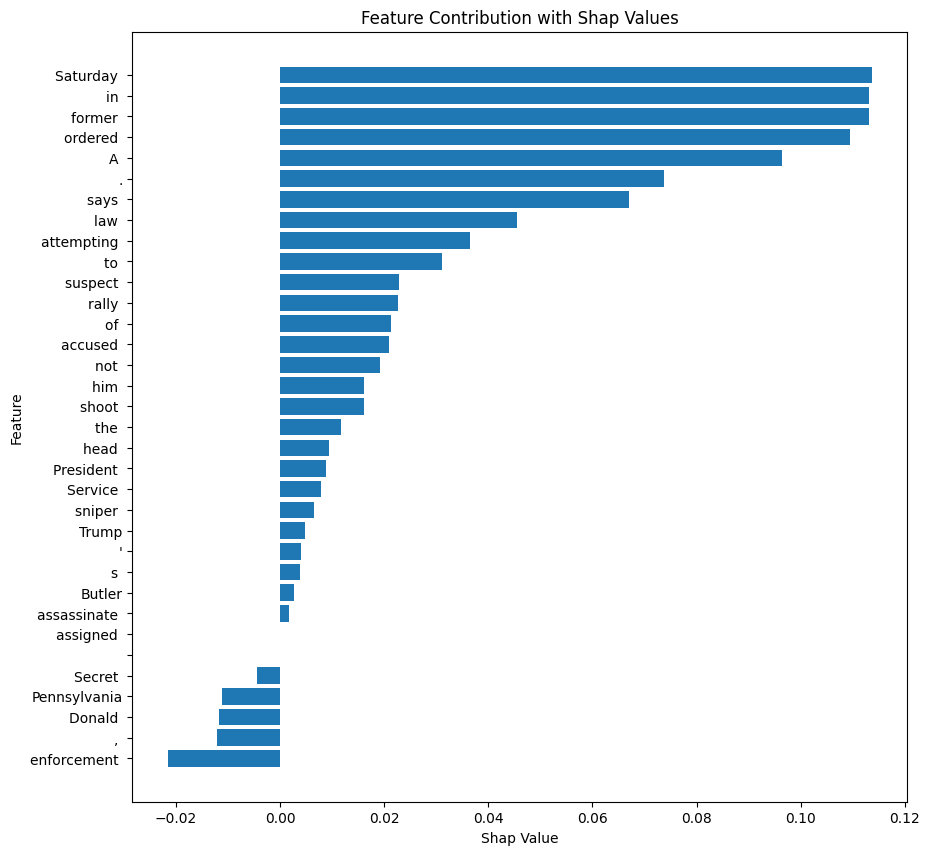

In [17]:
plt.figure(figsize=(10, 10))
plt.barh(sorted_shap_dict.keys(), sorted_shap_dict.values())
plt.title(f"Feature Contribution with Shap Values")
plt.ylabel("Feature")
plt.xlabel("Shap Value")
